# Суть эксперимента  

## Исходная идея  
Google обучал модифицированную LSTM на задачу сентимент-анализа и обнаружил, что в эмбеддингах (на определённых позициях) закодирован сентимент. В некоторых случаях до 90% комментариев можно корректно классифицировать, анализируя всего одну позицию в эмбеддинге.  

## Цель эксперимента  
Повторить этот эффект на BERT, дообучив его на задаче сентимент-анализа с помощью LoRA.  

### Почему BERT?  
- Это энкодерная модель, специализирующаяся на генерации качественных эмбеддингов.  
- Добавим линейную голову для классификации.  

### Почему LoRA?  
- Интересно попрактиковаться в использовании этого метода.  
- Эффективный способ тонкой настройки больших моделей.  

## Методика поиска "сентиментной" позиции  
1. После обучения отключаем линейный классификатор.  
2. На эмбеддингах дообучаем логистическую регрессию с L1-регуляризацией.  
3. Анализируем, какие позиции в эмбеддинге (из 768) наиболее важны для классификации.  

## Ожидаемый результат  
Надеемся обнаружить, что одна/несколько позиций в эмбеддинге действительно кодируют сентимент, как это было в LSTM.  

In [ ]:
import pandas as pd
import re
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from peft import LoraConfig, get_peft_model, TaskType,PeftModel
from torch.optim import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [ ]:
# Посмотрим на данные
data = pd.read_csv('IMDB Dataset.csv')

data.sample(5)['review'].values

array(["Very good political thriller regarding the aftermath of terrorism and the using of political torture to obtain one's objectives in flushing out the terrorists.<br /><br />The story is interwoven where two families are adversely affected by the terrorist events.<br /><br />This is one of Meryl Streep's best roles in years. She plays a cold, calculating, cunning director of the CIA who allows these things to go on. She is out of the George Bush-Dick Cheney school of handling the war on terrorism. Had her part been expanded, Miss Streep certainly would have been up for an award at Oscar time.<br /><br />Jake Gyllenhaal is our hero. A CIA agent who really can't take what's going on.<br /><br />We have a terrorist who actually has a heart and it costs him his life in this well directed, finely paced film.<br /><br />Alan Arkin appears briefly in the part of a conniving senator. Mr. Arkin seems to get better with age.",
       'It\'s actually a good thing Sean Connery retired as Jame

In [ ]:
#Базовая очистка текста
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\x96', '—', text)
    text = re.sub(r'\s+', ' ', text) 
    return text

data['review'] = data['review'].apply(clean_text)
data.to_csv('IMDB Dataset Cleaned.csv', index=False)


In [ ]:
class dataset(Dataset):
    def __init__(self, path,tokenizer,max_length=128):
        self.path = path
        self.data = pd.read_csv(path)
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = str(self.data.iloc[idx]['review'])
        label = 1 if self.data.iloc[idx]['sentiment'] == 'positive' else 0
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [5]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
data = dataset('IMDB Dataset Cleaned.csv',tokenizer)

In [6]:
train_size = int(0.8 * len(data))
val_size = len(data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,num_workers = 0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False,num_workers = 0)

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2) # Тут забыл указать output_hidden_states=True, но это не критично для LoRA

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,  # Rank
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    target_modules=["query", "value"],
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


optimizer = AdamW(model.parameters(), lr=5e-5)

trainable params: 591,362 || all params: 110,075,140 || trainable%: 0.5372


Эпоха 0: 100%|██████████| 5000/5000 [3:27:48<00:00,  2.49s/it]  

Эпоха 1, Ошибка: 0.3695


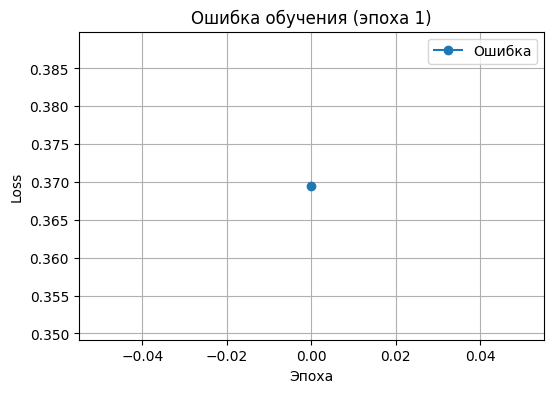

Эпоха 1: 100%|██████████| 5000/5000 [3:17:29<00:00,  2.37s/it]  

Эпоха 2, Ошибка: 0.2980


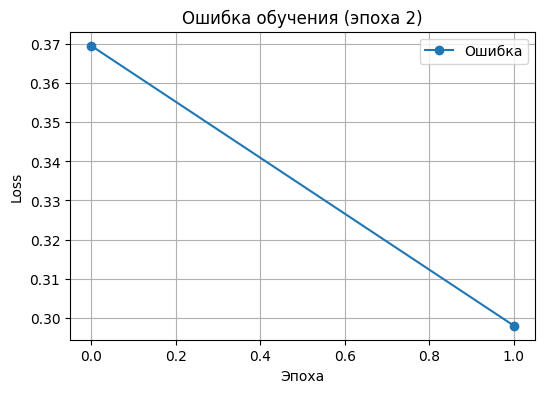

Эпоха 2: 100%|██████████| 5000/5000 [3:20:32<00:00,  2.41s/it]  

Эпоха 3, Ошибка: 0.2788


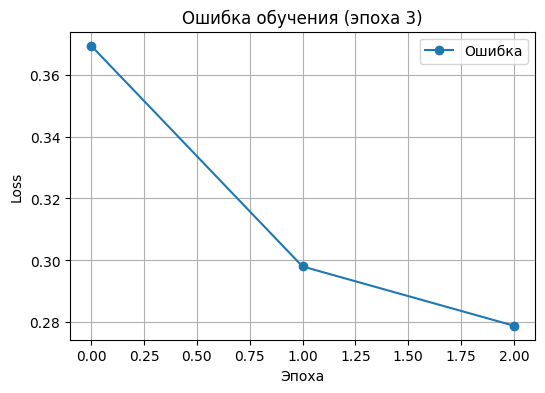

Эпоха 3:   4%|▍         | 200/5000 [07:46<3:06:34,  2.33s/it]


KeyboardInterrupt: 

In [ ]:
train_losses = [] 

for epoch in range(3):
    model.train()
    epoch_loss = 0.0
    
    for batch in tqdm(train_loader, desc=f"Эпоха {epoch}"):
        output = model(**batch)
        loss = output.loss
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    # Средняя ошибка за эпоху
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Вывод информации и график после каждой эпохи
    print(f"Эпоха {epoch + 1}, Ошибка: {avg_loss:.4f}")
    
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, marker='o', label='Ошибка')
    plt.title(f"Ошибка обучения (эпоха {epoch + 1})")
    plt.xlabel("Эпоха")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def evaluate(model, val_loader, device):
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validation'):
            inputs = {k: v.to(device) for k, v in batch.items() 
                     if k in ['input_ids', 'attention_mask', 'token_type_ids']}
            labels = batch['labels'].to(device)
            
            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1']))
    
    return {
        'val_loss': val_loss / len(val_loader),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

val_metrics = evaluate(model, val_loader, device)
print(f"\nValidation Metrics: {val_metrics}")

Validation: 100%|██████████| 1250/1250 [19:14<00:00,  1.08it/s]


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.89      0.88      0.89      4971
     Class 1       0.89      0.89      0.89      5029

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


Validation Metrics: {'val_loss': 0.27444062385708096, 'accuracy': 0.8867, 'precision': 0.8867183968274771, 'recall': 0.886679367893936, 'f1': 0.8866914236738579}


In [ ]:
model.save_pretrained("lora_bert")
base_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2,output_hidden_states=True)
model1 = PeftModel.from_pretrained(base_model, "lora_bert")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
df = pd.DataFrame(columns= [*range(768),'label'])
with torch.no_grad():
    model1.eval()
    for batch in tqdm(val_loader, desc='Validation'):
        output = model1(**batch)
        hidden_states = output.hidden_states[-1][:, 0, :]
        df2 = pd.DataFrame(hidden_states.cpu().numpy())
        df2['label'] = batch['labels'].cpu().numpy()
        df = pd.concat([df, df2], axis=0)
        


Validation:   0%|          | 0/1250 [00:00<?, ?it/s]/tmp/ipykernel_36216/2515031816.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df2], axis=0)
Validation: 100%|██████████| 1250/1250 [18:48<00:00,  1.11it/s]


In [130]:
from sklearn.linear_model import LogisticRegression

x = df.drop(columns=['label'])
y = df['label']
y = y.astype(int)

log_reg = LogisticRegression(max_iter=1000,penalty='l1',solver='saga')
log_reg.fit(x, y)

,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'saga'
,max_iter,1000
,multi_class,'deprecated'


In [131]:
print('Топ важных фичей для сентимент анализа:')
display(pd.DataFrame(log_reg.coef_, columns=x.columns).T.sort_values(by=0, ascending=False).head(3))

print('Топ важных фичей для сентимент анализа с конца:')
display(pd.DataFrame(log_reg.coef_, columns=x.columns).T.sort_values(by=0, ascending=False).tail(3))

Топ важных фичей для сентимент анализа:


,0
269,1.030492
225,0.984491
736,0.951776


Топ важных фичей для сентимент анализа с конца:


,0
201,-0.935457
100,-1.033736
124,-1.052353


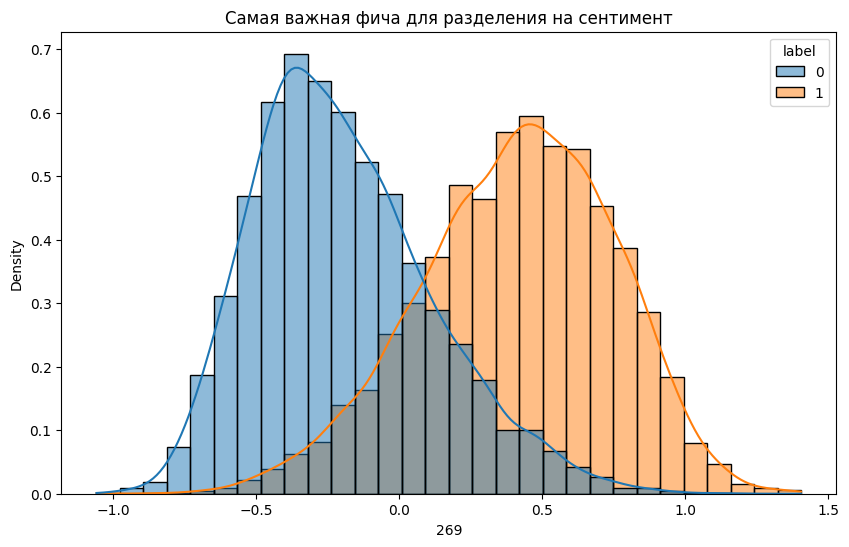

In [132]:
plt.figure(figsize=(10, 6))
sns.histplot(df, x=269, bins=30, kde=True, hue='label', stat='density')
plt.title('Самая важная фича для разделения на сентимент')
plt.show()

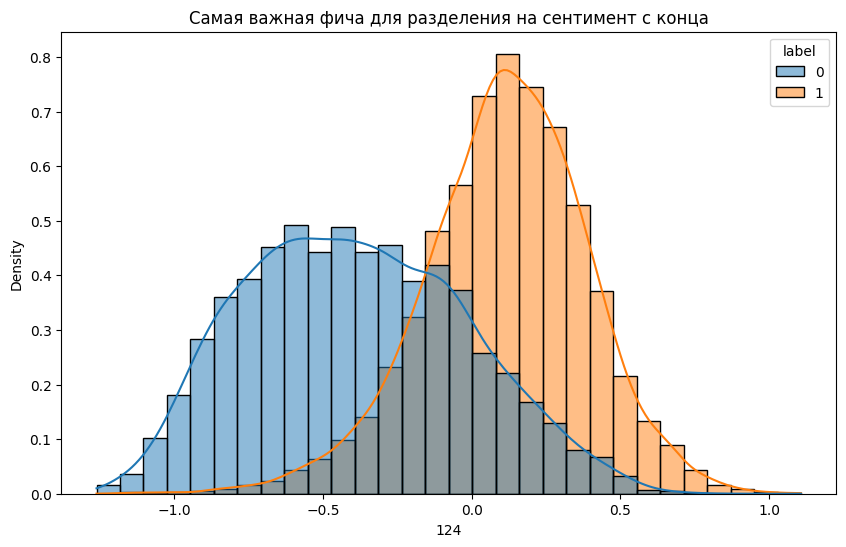

In [133]:
plt.figure(figsize=(10, 6))
sns.histplot(df, x=124, bins=30, kde=True, hue='label', stat='density')
plt.title('Самая важная фича для разделения на сентимент с конца')
plt.show()

# А теперь взглянем на вторые по порядку важные фичи

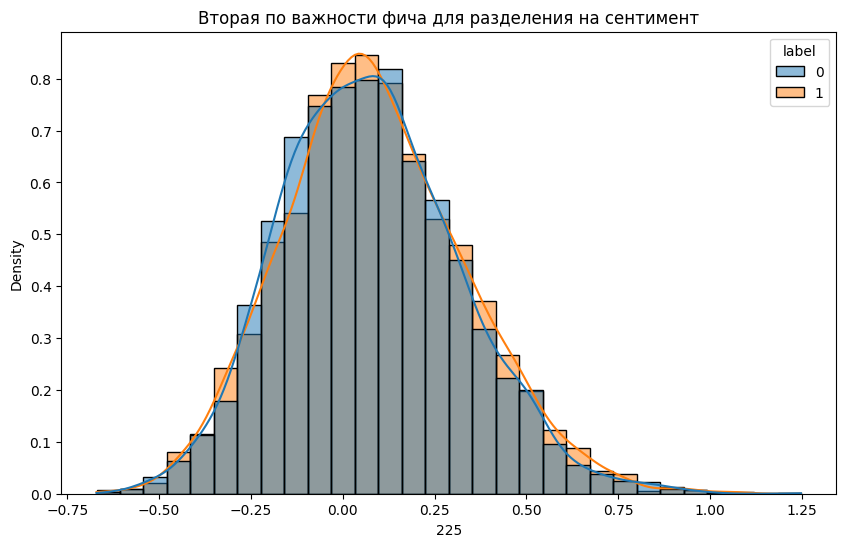

In [134]:
plt.figure(figsize=(10, 6))
sns.histplot(df, x=225, bins=30, kde=True, hue='label', stat='density')
plt.title('Вторая по важности фича для разделения на сентимент')
plt.show()

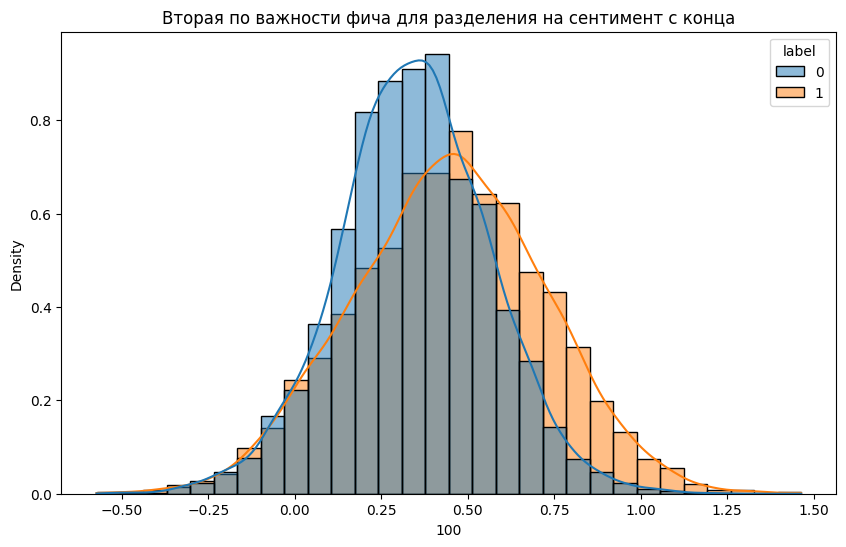

In [135]:
plt.figure(figsize=(10, 6))
sns.histplot(df, x=100, bins=30, kde=True, hue='label', stat='density')
plt.title('Вторая по важности фича для разделения на сентимент с конца')
plt.show()

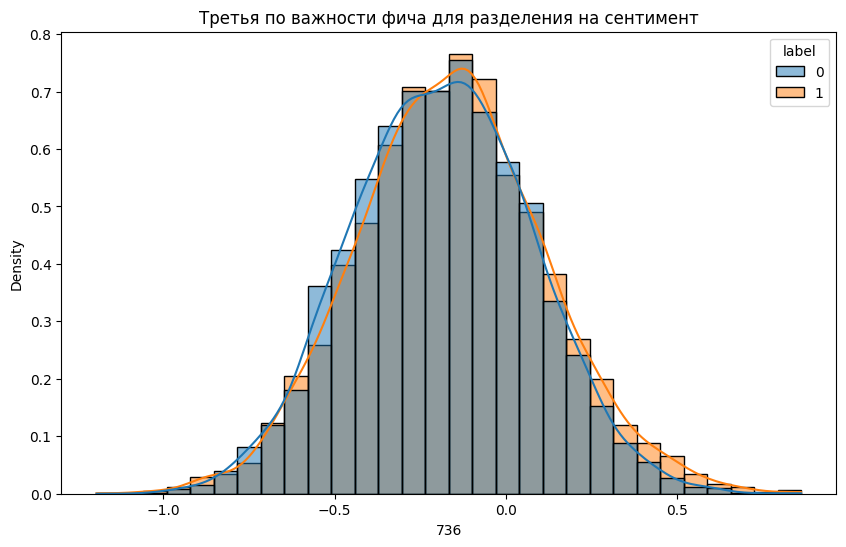

In [136]:
plt.figure(figsize=(10, 6))
sns.histplot(df, x=736, bins=30, kde=True, hue='label', stat='density')
plt.title('Третья по важности фича для разделения на сентимент')
plt.show()

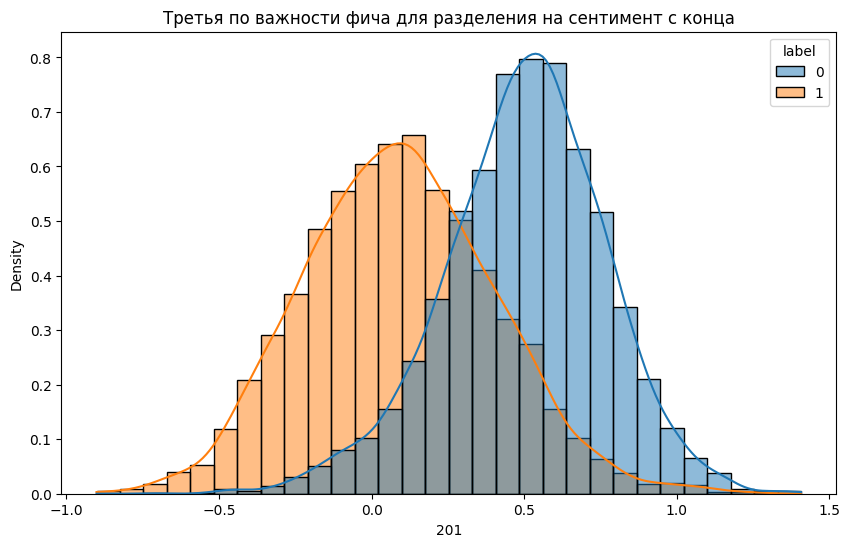

In [137]:
plt.figure(figsize=(10, 6))
sns.histplot(df, x=201, bins=30, kde=True, hue='label', stat='density')
plt.title('Третья по важности фича для разделения на сентимент с конца')
plt.show()

In [138]:
print(f'Ошибка сейча на данных: {log_reg.score(x, y)}')

Ошибка сейча на данных: 0.9087


In [139]:
x_new = x[[269]] #Перечислили самые важные фичи
log =  LogisticRegression()
log.fit(x_new, y)
print(f'Ошибка на данных с двумя фичами: {log.score(x_new, y)}')
# То есть оставив только одну фичу, мы всё ещё можем достичь хорошей точности модели, что говорит о том, что эта фича действительно важна для сентимент анализа.

Ошибка на данных с двумя фичами: 0.824


In [140]:
# Рассмотрим для 201 фичи, которая была третьей по важности с конца
x_new = x[[201]] #Перечислили самые важные фичи
log =  LogisticRegression()
log.fit(x_new, y)
print(f'Ошибка на данных с двумя фичами: {log.score(x_new, y)}')
#Тут результат хуже, чем для 269 фичи, но все равно вносит вклад

Ошибка на данных с двумя фичами: 0.7736


# Небольшое заключение

В итоге да, модель хранит в своих векторах информацию о сентименте при помощи которой можно достигать хороших результатов, используя только 1 фичу